In [7]:
# !unzip Registered.zip # unzip your file of images here. 

# update box credentials, imgs_per_line and desired_views before running. 
# tweak the cropping in the load_transform and in the crop_lightfield functions. 

In [8]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import tqdm
import cv2
import time
import os

from lightfield_utils import load_lightfield_from_paths, resize_lightfield, load_lightfield, save_rendered_views
from lightfield_canvas import DisplayLF

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#configure: images per line, desired views
imgs_per_line = 29
desired_views = [144, 192]

file_suffix=".png"
lf_path = Path("Registered/")
image_paths = list(lf_path.iterdir())

def sorting_key(filepath):
    """
    returns a filename that can be used for sorting
    """
    number = int(filepath.name.strip("reg.png"))
    return f"{number:03d}"

image_paths = sorted(image_paths, key= sorting_key)
image_paths = [path for path in image_paths if str(path).endswith(file_suffix)]
image_paths[:5]

[PosixPath('Registered/1reg.png'),
 PosixPath('Registered/2reg.png'),
 PosixPath('Registered/3reg.png'),
 PosixPath('Registered/4reg.png'),
 PosixPath('Registered/5reg.png')]

In [16]:
def load_transform(image):
    # implemented this transform for a lightfield capturated in a 90º angle (rotated) that was far away
    # to process the rotation and crop before resize is applied, not after to preserve resolution. 
    # also applies a 0.9º rotation to correct the image. 
    new_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    angle= .9
    image_center = tuple(np.array(new_image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    new_image = cv2.warpAffine(new_image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    new_image = new_image[2570:3400, 1450:2420]
    return new_image

lf = load_lightfield_from_paths(image_paths[:], imgs_per_line, resize=(572*2, 440*2), transform= load_transform)
print("loaded lightfield with shape", lf.shape, "and dtype", lf.dtype)

100%|██████████| 609/609 [04:15<00:00,  2.39it/s]

loaded lightfield with shape (21, 29, 880, 1144, 3) and dtype uint8


In [17]:
# transpose and reverse array appropiately unitl the DisplayLF shows correctly
new_lf = np.moveaxis(lf, [0,1,2,3,4], [1,0,2,3,4])
new_lf = new_lf [::-1]

DisplayLF(new_lf, width= 572, height= 440).show()

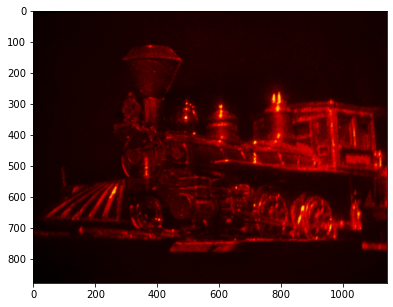

In [19]:
# crop to the borders of the lf using the sample
sample = new_lf[6, 15]
cutx = (0, -1)
cuty = (0, -1)

sample = sample[cuty[0]: cuty[1],cutx[0]: cutx[1],:]

plt.figure(figsize= (10, 5))
plt.imshow(np.uint8(sample))

In [20]:
#visualize result on entire lightfield
cropped_lf = new_lf[:, :, cuty[0]: cuty[1],cutx[0]: cutx[1],:]
DisplayLF(cropped_lf, width= 572, height= 440).show()

In [21]:
datetime_str = datetime.datetime.today().strftime("%Y_%m_%d_%H_%M")
dst = Path("raw_benton_lightfield_" + datetime_str +".npy")

np.save(dst, cropped_lf)
print("Saved new lightfield in", dst)

saved_lf = load_lightfield(dst)
# DisplayLF(saved_lf, width= 572, height= 440).show()

Saved new lightfield in raw_benton_lightfield_2021_05_12_19_53.npy
Loaded lightfield with dtype: uint8 and shape: (29, 21, 879, 1143, 3)


In [22]:
resized_lf = resize_lightfield(saved_lf, (572, 440))

transposed_lf = np.moveaxis(resized_lf, [0,1,2,3,4], [2,3,0,1,4])

In [23]:
new_shape = list(transposed_lf.shape)[:2] + desired_views + [3]
result = np.zeros(new_shape, dtype= np.uint8)

for i, row in enumerate(tqdm.tqdm(transposed_lf)):
    for j, diffraction in enumerate(row):
        res = cv2.resize(diffraction, tuple(desired_views[::-1]), interpolation= cv2.INTER_LINEAR)
        result[i,j] = np.uint8(res)
        
result = np.moveaxis(result, [0,1,2,3,4], [2,3,0,1,4])

100%|██████████| 440/440 [00:29<00:00, 14.81it/s]


In [24]:
downsampled_result = result[::3, ::3] #can't display more than roughly 100x100 views, so just downsample by 3. 
print(result.shape, result.dtype)
DisplayLF(downsampled_result, width=572, height=440).show()

(144, 192, 440, 572, 3) uint8


In [25]:
datetime_str = datetime.datetime.today().strftime("%Y_%m_%d_%H_%M")
n_u, n_v, n_y, n_x, _ = result.shape
output_filename = Path(f"rendered_views_benton_{n_u}x{n_v}x{n_y}x{n_x}_" + datetime_str + ".npy")

np.save(output_filename, result)
print("Saved rendered lightfield in", output_filename)

saved_lf = load_lightfield(output_filename)
# DisplayLF(saved_lf[::5, ::5]).show()

Saved rendered lightfield in rendered_views_benton_144x192x440x572_2021_05_12_19_54.npy
Loaded lightfield with dtype: uint8 and shape: (144, 192, 440, 572, 3)


In [ ]:
rendered_lightfield = saved_lf
output_folder = Path(".") / "rendered_views" / str(output_filename)[:-4] # reuse .npy filename as folder name

save_rendered_views(output_folder, rendered_lightfield)

 23%|██▎       | 33/144 [04:52<16:48,  9.08s/it]

In [ ]:
from boxsdk import DevelopmentClient, OAuth2, Client
from boxsdk.network.default_network import DefaultNetwork
import shutil


# Define client ID, client secret, and developer token.
CLIENT_ID = None
CLIENT_SECRET = None
ACCESS_TOKEN = None

# Read app info from text file
with open('box_credentials.txt', 'r') as app_cfg:
    """
    This is a .txt file with 3 lines
    CLIENT_ID
    CLIENT_SECRET
    ACCESS_TOKEN (the developer token)
    find at https://northwestern.app.box.com/developers/console/app/1484448/configuration 
    """
    CLIENT_ID = app_cfg.readline()
    CLIENT_SECRET = app_cfg.readline()
    ACCESS_TOKEN = app_cfg.readline()

oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

# Create the authenticated client
client = Client(oauth2)
root_folder = client.folder('0').get()

In [ ]:
target_folder = None

for item in root_folder.get_items():
    print(item)
    if item.name=="LensCalibrated_6s":
        target_folder = item

In [ ]:
#make a new folder for the rendered views
tmp_filename = "tmp_" + str(time.time()) + ".zip"
shutil.make_archive(tmp_filename[:-4], 'zip',output_folder)
#upload zip to box
target_folder.upload(tmp_filename, output_folder.name+".zip")
os.remove(tmp_filename)